#Importing libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets
from sklearn.model_selection import train_test_split as tts
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import  train_test_split as tts
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#Problem 1

##Part 1

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)


100%|██████████| 9912422/9912422 [00:00<00:00, 138671680.59it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 51811674.01it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35091797.22it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 10165703.72it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
X=mnist_trainset.data.numpy()
y=mnist_trainset.targets.numpy()

In [ ]:
X_train,X_valid,y_train,y_valid=tts(X,y,test_size=0.3)
print(X_train.shape,X_valid.shape)

(42000, 28, 28) (18000, 28, 28)


In [ ]:
mean_train = mnist_trainset.data.float().mean() / 255
std_train = mnist_trainset.data.float().std() / 255
mean_test = mnist_testset.data.float().mean() / 255
std_test = mnist_testset.data.float().std() / 255


In [ ]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean_train], std=[std_train])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean_test], std=[std_test])
                                     ])

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_transforms)

In [ ]:
train_dataset, val_dataset = random_split(train_dataset, [42000, 18000])

In [ ]:
val_dataset.transform = test_transforms

##Part 2

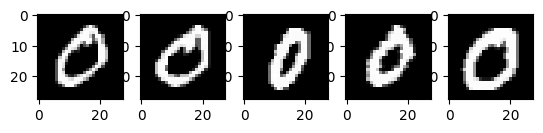

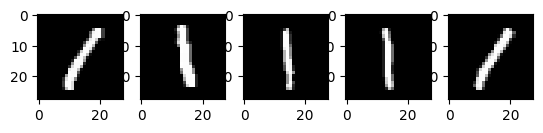

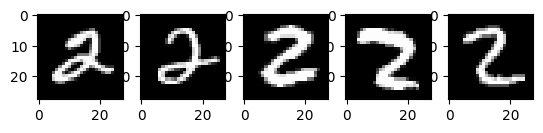

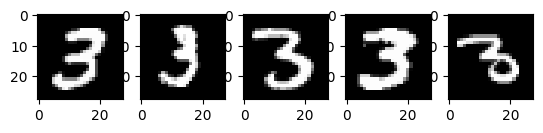

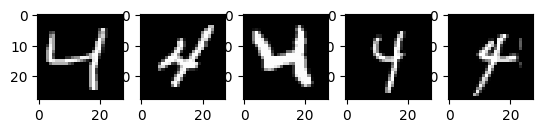

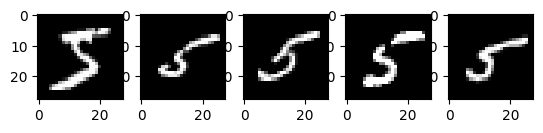

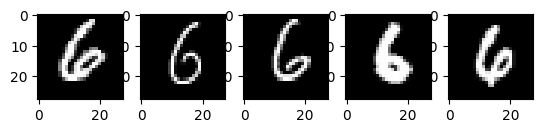

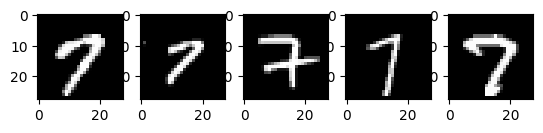

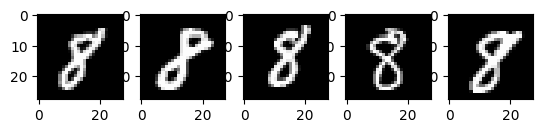

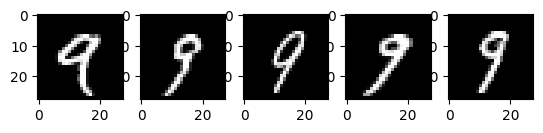

In [ ]:
X_temp=train_dataset.dataset.data.numpy()
y_temp=train_dataset.dataset.targets.numpy()
n=5

for i in range(0,10):
    idx=np.where(y==i)[0]
    idx=idx[:n]
    for cnt,index in enumerate(idx):
        plt.subplot(1,n,cnt+1)
        plt.imshow(X_temp[index],cmap='gray')
    plt.show()

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

##Part 3

In [ ]:
class MLP(nn.Module):
    def __init__(self,input_size,hidden_size_1,hidden_size_2,output_size):
        super(MLP,self).__init__()
        self.w1=nn.Linear(input_size,hidden_size_1)
        self.w2=nn.Linear(hidden_size_1,hidden_size_2)
        self.w3=nn.Linear(hidden_size_2,output_size)

    def forward(self,x):
        x=self.w1(x)
        x=nn.functional.relu(x)
        x=self.w2(x)
        x=nn.functional.relu(x)
        x=self.w3(x)
        return x


In [ ]:

mlp=MLP(28*28,256,256,10)
no_of_trainable_parameters=0
for p in mlp.parameters():
    if(p.requires_grad):
        no_of_trainable_parameters+=p.numel()

print('No of trainable parameters are ',no_of_trainable_parameters)

No of trainable parameters are  269322


##Part 4

In [ ]:
num_epochs=5                                #defining the number of epochs/iterations

optimizer=optim.Adam(mlp.parameters())      #defining the optimizer as Adam optimizer
loss_func=nn.CrossEntropyLoss()             #defining loss function as cross entropy loss


#initilizing the arrays that will the store the accuracy and loss for training and validation data for each epoch
train_accs=[]
train_losses=[]
val_accs=[]
val_losses=[]

#best model will store the model that will give highest accuracy on validation dataset and bezt_val_acc its accuracy
best_val_acc=0
best_model=mlp

for epoch in range(num_epochs):
    mlp.train()                             #setting the mlp to train mode
    train_acc=0                             #initializing training accuracy
    train_loss=0                            #initializing training loss


#this loop will run for each batch in train loader and train the mlp
    for inputs,labels in train_loader:      

        #forward propagation
        optimizer.zero_grad()               #initialzing the previous derivatives to zero since we are starting a new iteration. Optimizer used to store the previous derivatives so that can be used later to calculate the loss and update parameters
        inputs=inputs.reshape(-1,28*28)     #reshaping the image data to compatible with the number of nodes in the input layer
        outputs=mlp(inputs)                 #calculating the output of the mlp for the given input samples
        
        loss=loss_func(outputs,labels)      #calculating the loss
        

        #backward propagation
        loss.backward()                     #backward propagating the loss and calculating the error in the weights and biases
        optimizer.step()                    #updating the weights and biases


        #calculating the accuracy and loss 
        train_loss+=loss.item()*inputs.size(0)      #multiplying with size of batch because in the last we are going to divide the loss and accuracy by the lenght of dataset
        _,predicted=torch.max(outputs.data,1)       #class with highest probability is the predicted class
        train_acc+=(predicted==labels).sum().item()


    #dividing the train loss with lenght of training dataset to get mean loss and accuracy    
    train_loss=train_loss/len(train_dataset)        
    train_acc=train_acc/len(train_dataset)

    #setting the mlp to evaluating mode
    mlp.eval()

    #initializing the validation loss and accuracy
    val_loss=0
    val_acc=0


    # calling torch.no_grad since we don't want to train the mlp on validation dataset. This will prevent the updation of the weights and biases
    with torch.no_grad():
        for inputs,labels in val_loader:

            #forward propagation
            inputs=inputs.reshape(-1,28*28)
            outputs=mlp(inputs)

            #calculating the loss
            loss=loss_func(outputs,labels)

            #calculating validation loss and accuracy
            val_loss+=loss.item()*inputs.size(0)
            _,predicted=torch.max(outputs.data,1)
            val_acc+=(predicted==labels).sum().item()

            



                


    val_loss=val_loss/len(val_dataset)
    val_acc=val_acc/len(val_dataset)

    #storing the model with best validation accuracy
    if(best_val_acc<val_acc):
        best_val_acc=val_acc
        best_model=mlp


    #appending the loss and accuracy for training and testing dataset for later use
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)


    #printing the loss and accuracy for training and testing dataset for each epoch
    print(f'Epoch {epoch+1}/{num_epochs}: train_loss: {train_loss}, train_accuracy: {train_acc}, val_loss: {val_loss}, val_accuracy: {val_acc}')



    




    
        




Epoch 1/5: train_loss: 0.427648909392811, train_accuracy: 0.8658571428571429, val_loss: 0.19254267569382985, val_accuracy: 0.9387222222222222
Epoch 2/5: train_loss: 0.17658629707601808, train_accuracy: 0.9444761904761905, val_loss: 0.18608793167273205, val_accuracy: 0.9438333333333333
Epoch 3/5: train_loss: 0.14374302809153283, train_accuracy: 0.9548333333333333, val_loss: 0.13693338375290234, val_accuracy: 0.9596111111111111
Epoch 4/5: train_loss: 0.12217633931977408, train_accuracy: 0.9611666666666666, val_loss: 0.1228022087348832, val_accuracy: 0.9623888888888888
Epoch 5/5: train_loss: 0.11241747491771266, train_accuracy: 0.9648095238095238, val_loss: 0.12568898743225468, val_accuracy: 0.9627222222222223


In [ ]:
correct_images=[]
correct_images_labels=[]
correct_images_preds=[]

incorrect_images=[]
incorrect_images_labels=[]
incorrect_images_preds=[]

best_model.eval()
with torch.no_grad():
    for inputs,labels in val_loader:
        inputs=inputs.reshape(-1,28*28)
        outputs=mlp(inputs)

        _,predicted=torch.max(outputs.data,1)

        inputs=inputs.reshape(-1,28,28)
        inputs=inputs.numpy()
        predicted=predicted.numpy()
        labels=labels.numpy()

        for i,x in enumerate(inputs):
            if(predicted[i]==labels[i]):
                correct_images.append(inputs[i])
                correct_images_labels.append(labels[i])
                correct_images_preds.append(predicted[i])

            else:
                incorrect_images.append(inputs[i])
                incorrect_images_labels.append(labels[i])
                incorrect_images_preds.append(predicted[i])



print(len(correct_images),len(incorrect_images))




17278 722


In [ ]:
best_val_acc

0.9627222222222223

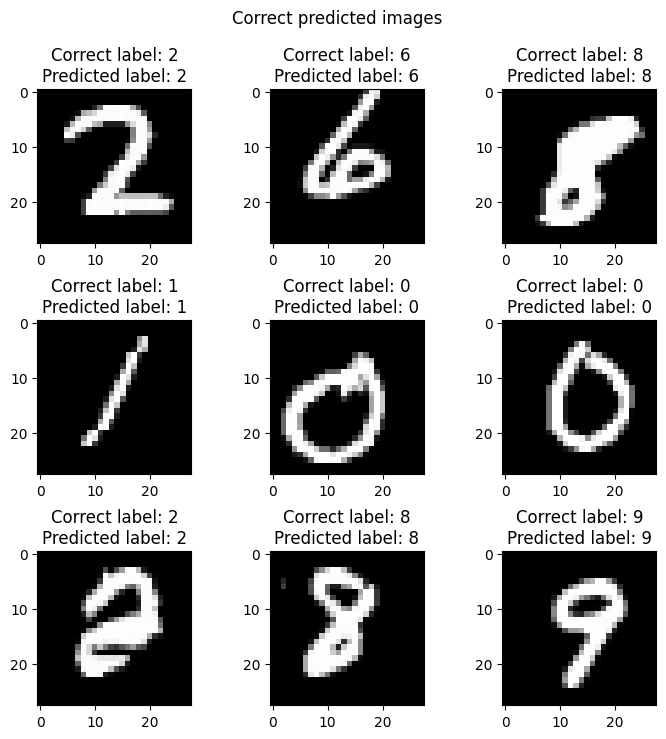

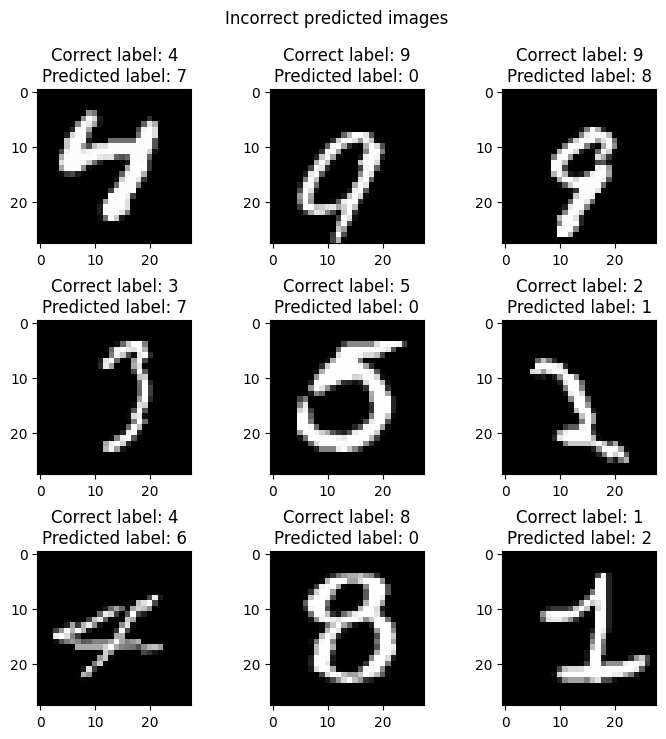

In [ ]:
def plot_correct_incorrect_images(rows,columns):
    no_of_images=rows*columns
    for title,images,true,pred in zip(['Correct predicted images','Incorrect predicted images'],[correct_images,incorrect_images],[correct_images_labels,incorrect_images_labels],[correct_images_preds,incorrect_images_preds]):
        fig, axes = plt.subplots(rows, columns, figsize=(8, 8))
        fig.subplots_adjust(hspace=0.5, wspace=0.5)
        
        for i, ax in enumerate(axes.flat):
            ax.imshow(images[i], cmap='gray')
            ax.set_title(f"Correct label: {true[i]}\nPredicted label: {pred[i]}")
        
        
        plt.suptitle(title)
        plt.show()
        print('\n\n')


plot_correct_incorrect_images(3,3)

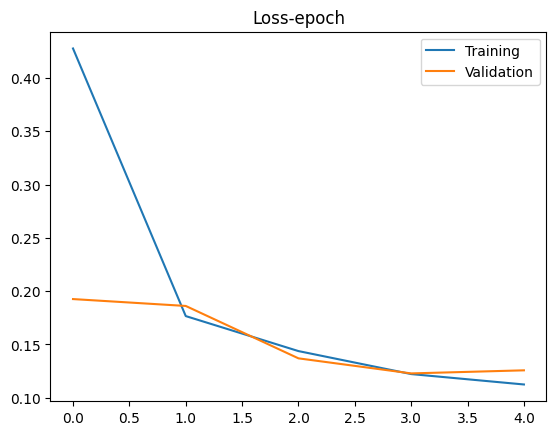

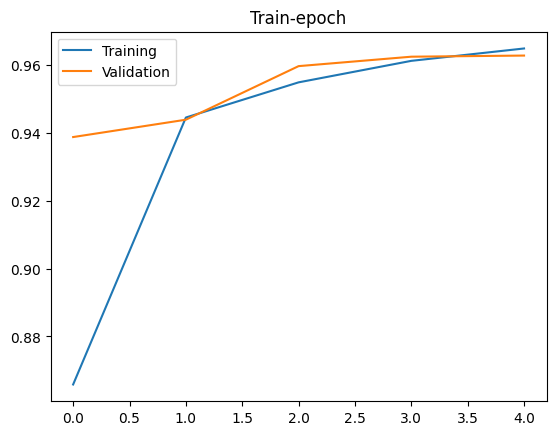

In [ ]:
for title,train,val in zip(['Loss-epoch','Train-epoch'],[train_losses,train_accs],[val_losses,val_accs]):
    plt.plot(train,label='Training')
    plt.plot(val,label='Validation')
    plt.title(title)
    plt.legend()
    plt.show()

#Problem 2

##Part 1

In [5]:
columns=['Sex','Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight','Rings']
df=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data',names=columns)
df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [6]:
df.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

In [7]:
class_no=[]
for n_rings in df['Rings']:
    if(n_rings<8):
        class_no.append(1)
    elif(n_rings<13):
        class_no.append(2)
    elif(n_rings<18):
        class_no.append(3)
    else:
        class_no.append(4)

df['Class']=class_no
df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Class
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,3
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,1
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,2
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,2
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,1
...,...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,2
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,2
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,2
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,2


In [8]:
df['Sex']=df['Sex'].replace(['M','F','I'],[0,1,2]).astype(int)
df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Class
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,3
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,1
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,2
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,2
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,1
...,...,...,...,...,...,...,...,...,...,...
4172,1,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,2
4173,0,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,2
4174,0,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,2
4175,1,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,2


In [9]:
df['Class'].value_counts()

2    2645
1     839
3     557
4     136
Name: Class, dtype: int64

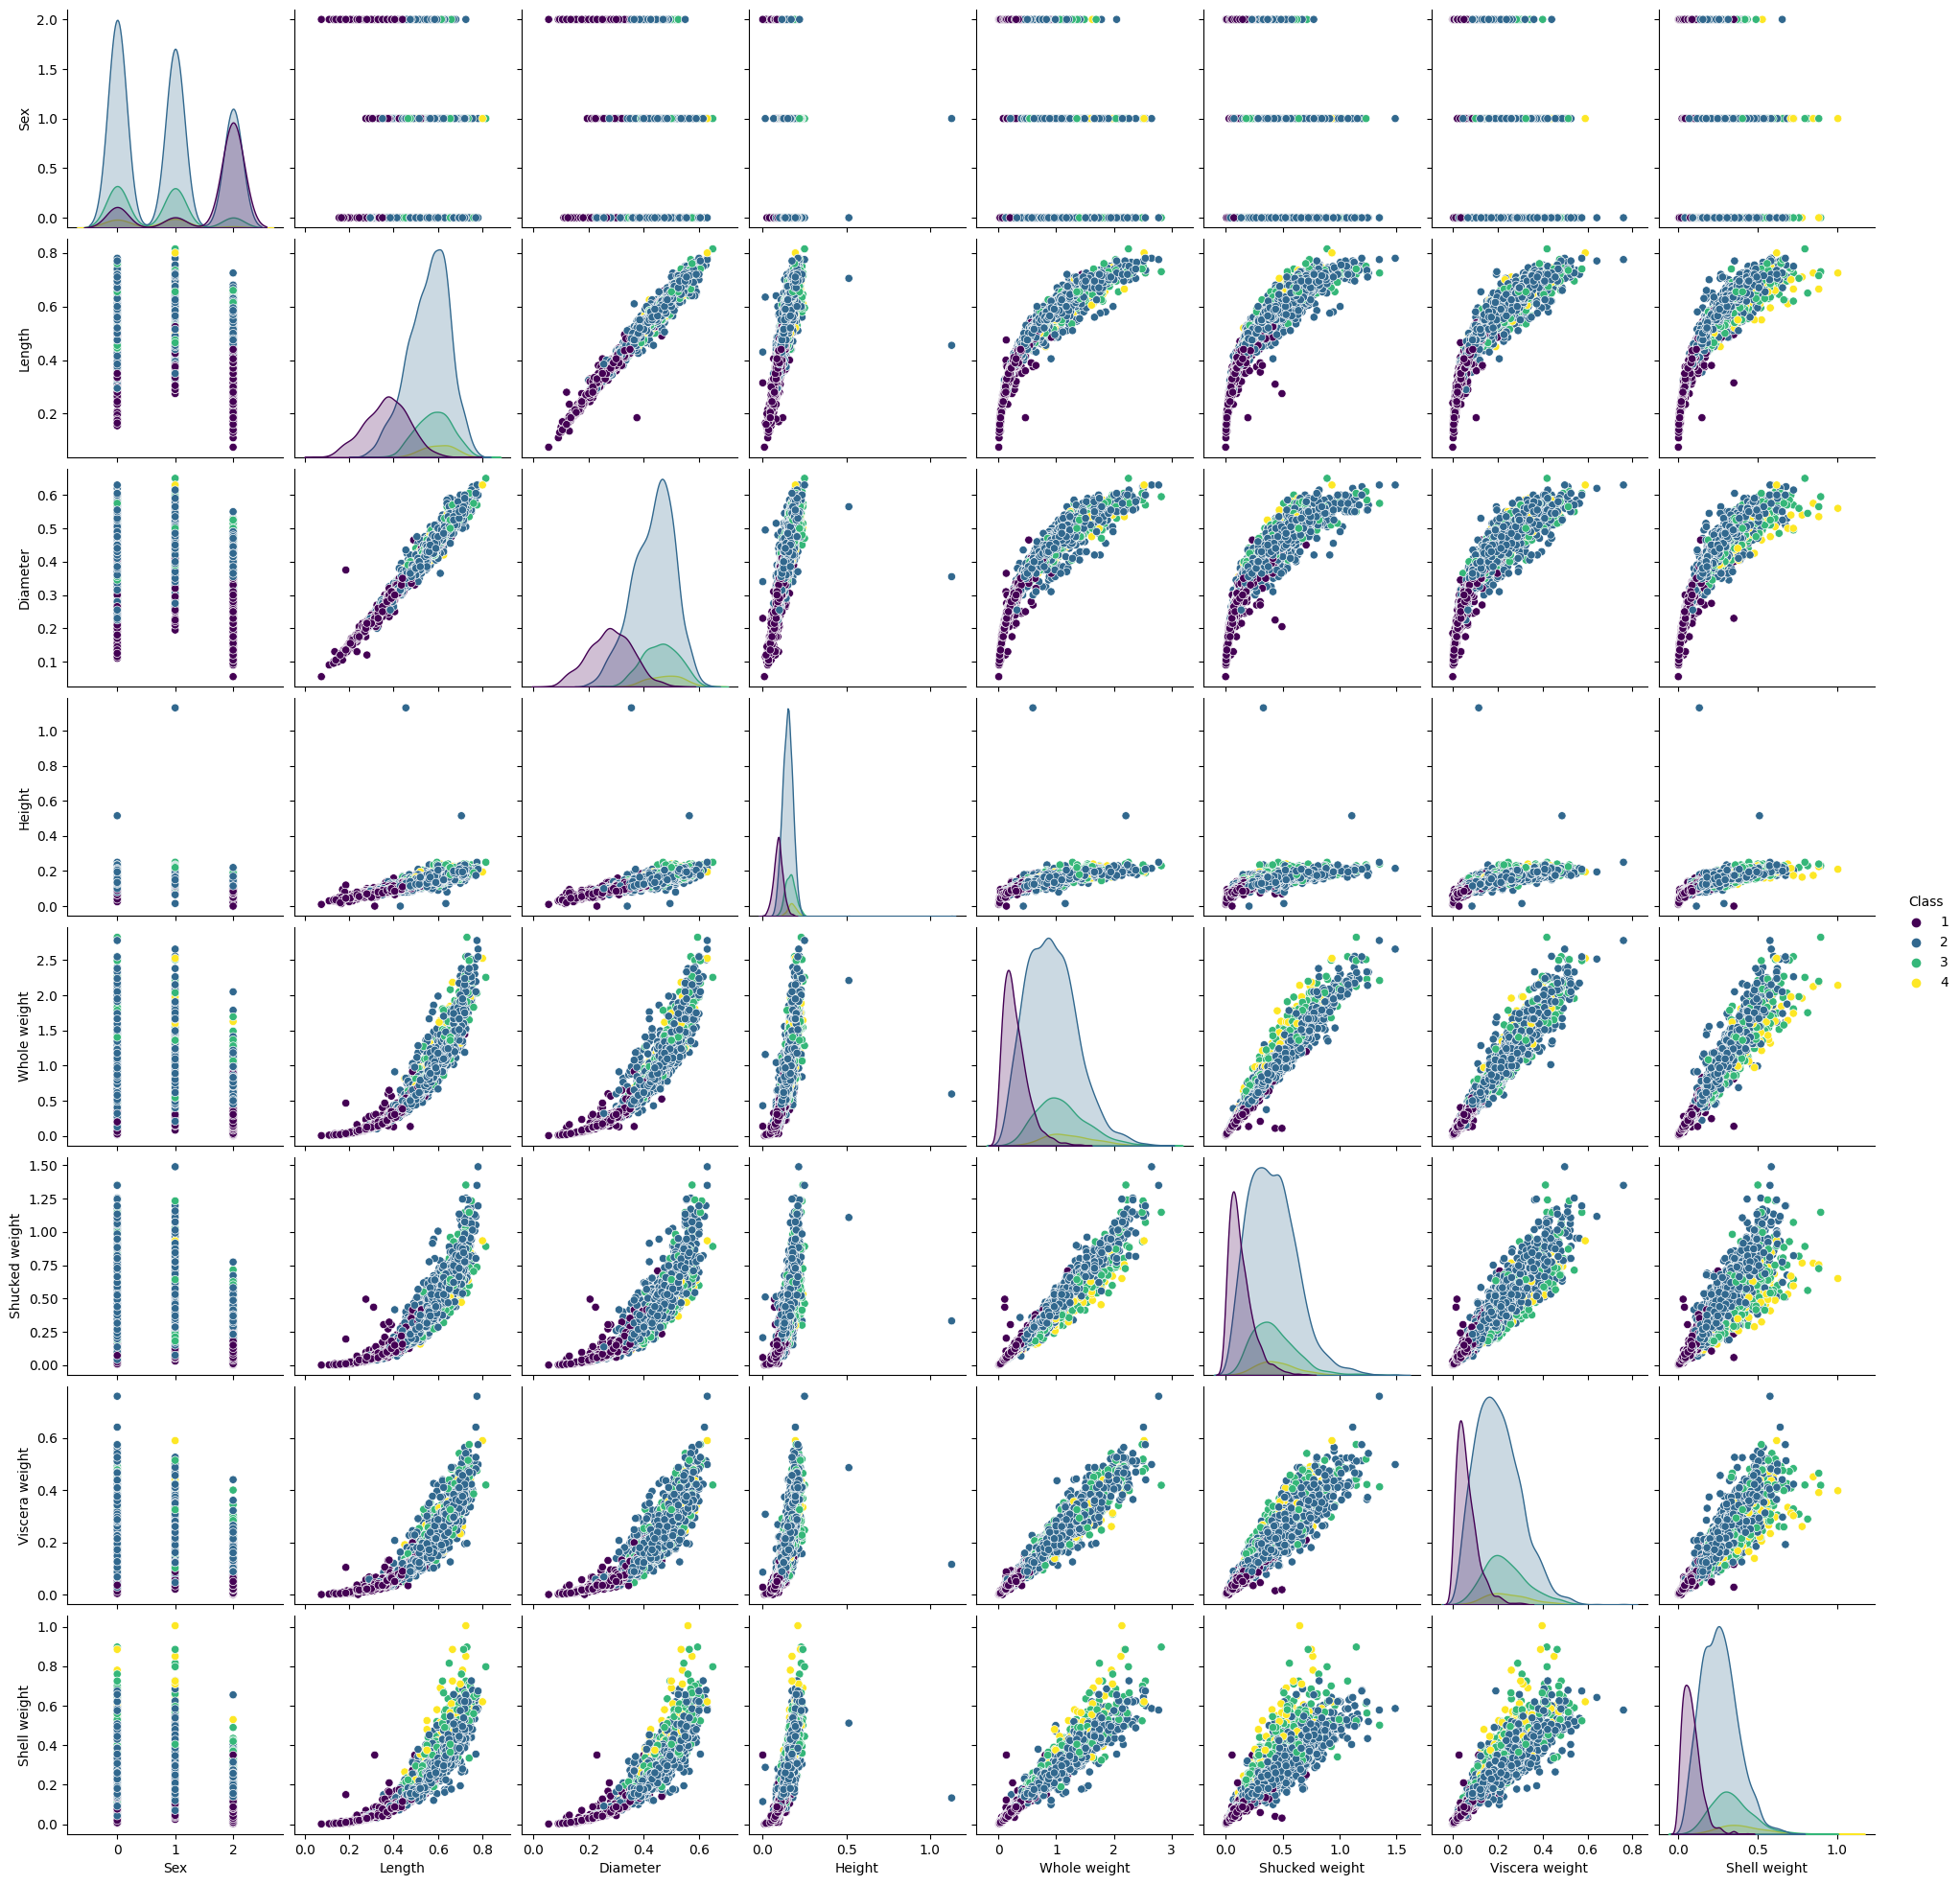

In [158]:
sns.pairplot(data=df.drop('Rings',axis=1),hue='Class',palette='viridis')

<Axes: >

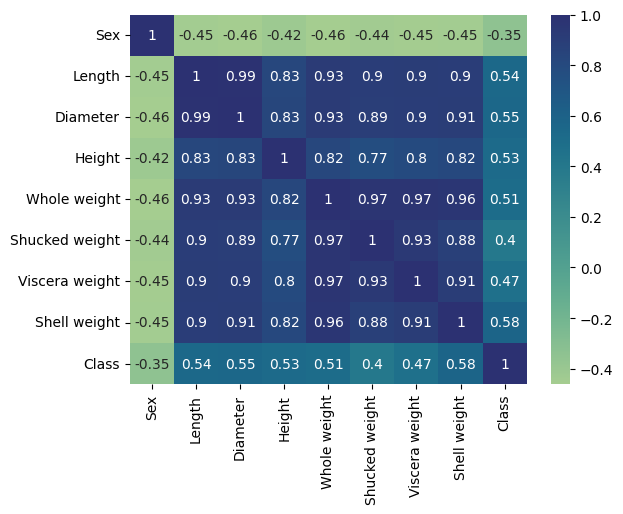

In [201]:

sns.heatmap(data=df.drop('Rings',axis=1).corr(),cmap='crest',annot=True)

In [10]:
X=df.drop(['Rings','Class'],axis=1).to_numpy()
y=df['Class'].to_numpy()
#split is going to be done in 50:20:30 ratio

std_sc=StandardScaler()
X=std_sc.fit_transform(X)

def startified_split(X,y,test_size):
    #initializing the splitted lists
    X_train=[]
    y_train=[]
    X_test=[]
    y_test=[]

    # for every label in y splitting its population in the given ratio/test_size
    for label in np.unique(y):
        idx=np.where(y==label)[0] #finding the samples having y==label
        np.random.shuffle(idx) #shufffling the indices
        split=(int)(len(idx)*test_size) #fnding the split index from where we can split idx list and assign it to train and test arrays
        
        #dividing the indices into train and test indices
        train_idx=idx[split:]
        test_idx=idx[:split]

        #if split is zero i.e. there are very less samples in the class such that we can't divide them in the given ratio, assign that class samples to both the lists
        if(split==0):
            X_train.extend(X[idx])
            y_train.extend(y[idx])
            X_test.extend(X[idx])
            y_test.extend(y[idx])

        #else split the given dataset on the basis of train and test indices
        else:
            X_train.extend(X[train_idx])
            y_train.extend(y[train_idx])
            X_test.extend(X[test_idx])
            y_test.extend(y[test_idx])
    return np.array(X_train),np.array(X_test),np.array(y_train),np.array(y_test)


X_temp,X_test,y_temp,y_test=startified_split(X,y,0.3)
X_train,X_valid,y_train,y_valid=startified_split(X_temp,y_temp,(0.2/0.7))
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape,X_valid.shape,y_valid.shape)

print()




(2091, 8) (1251, 8) (2091,) (1251,) (835, 8) (835,)



In [207]:
print('Classes present in training data along with their counts')
unique, counts = np.unique(y_train, return_counts=True)

print(np.asarray((unique, counts)).T)

print('Classes present in testing data along with their counts')
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

print('Classes present in validation data along with their counts')
unique, counts = np.unique(y_valid, return_counts=True)
print(np.asarray((unique, counts)).T)

Classes present in training data along with their counts
[[   1  420]
 [   2 1323]
 [   3  279]
 [   4   69]]
Classes present in testing data along with their counts
[[  1 251]
 [  2 793]
 [  3 167]
 [  4  40]]
Classes present in validation data along with their counts
[[  1 168]
 [  2 529]
 [  3 111]
 [  4  27]]


##Part 2

In [2]:
# the MLP class below consists of one input layer, one output layer and one hidden layer. The number of nodes in the layers can altered as required
class MLP:

    #initializing the parameters
    def __init__(self,input_size,hidden_size,output_size,activation_func,derivative_func,learning_rate=0.1,init_method='random',init_constant=5):
        # storing the parameters of the MLP i.e. number of nodes in each layer, activation function, weight initialization method and learning rate
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.output_size=output_size
        self.activation_func=activation_func
        self.derivative_func=derivative_func
        self.init_method=init_method
        self.init_constant=init_constant
        self.lr=learning_rate



    #function for random initialization of weights
    def random_init(self):
        self.w1=np.random.rand(self.hidden_size,self.input_size)
        self.b1=np.random.rand(self.hidden_size,1)
        self.w2=np.random.rand(self.output_size,self.hidden_size)
        self.b2=np.random.rand(self.output_size,1)
        
    


    #function to intialize all weights to zero
    def zero_init(self):
        self.w1=np.zeros((self.hidden_size,self.input_size))
        self.b1=np.zeros((self.hidden_size,1))
        self.w2=np.zeros((self.output_size,self.hidden_size))
        self.b2=np.zeros((self.output_size,1))
    



    #function to initialize all weights to a constant value
    def constant_init(self):
        self.w1=np.zeros((self.hidden_size,self.input_size))+self.init_constant
        self.b1=np.zeros((self.hidden_size,1))+self.init_constant
        self.w2=np.zeros((self.output_size,self.hidden_size))+self.init_constant
        self.b2=np.zeros((self.output_size,1))+self.init_constant




    #function to normalize the ouput of the MLP so that it becomes a probability distribution
    def softmax(self,X):
        X=X/(self.t) #here, t is temperature which is used to prevent overflow. We can alter its value by passing a parameter in train function
        return np.exp(X)/sum(np.exp(X))





    #function for one hot encoding of training labels, so that error/loss can be calculated
    def one_hot_y(self,y):
        labels=self.classes
        out=np.zeros((len(y),len(labels)))
        for i,label in enumerate(labels):
            idx=np.where(y==label)[0]
            out[idx,i]=1
        return out.T

    



    #function for calculating the output of MLP for a given sample input
    def forward_propagation(self,X):

        #transitioning from input layer to hidden layer
        z1=self.w1.dot(X)+self.b1               #multiplying the weights and adding biases to the sample
        a1=self.activation_func(z1)             # passing the outupt to the activation function

        #transitioning from hidden layer to output layer
        z2=self.w2.dot(a1)+self.b2
        a2=self.activation_func(z2)             #final output of neural network

        #applying softmax fuction to output to represent output as a probability distribution and class with highest probability is the predicted class for the sample
        a2=self.softmax(z2)
        
        return z1,a1,z2,a2




    #Backward propagation to calculate error in the prediction whose output is later used to update the weights and biases
    def back_propagation(self,z1,a1,z2,a2,X,y):
        m=len(y)
        #one hot encoding the training labels to calculate the ideal output of the neural network
        one_hot_Y = self.one_hot_y(y)

        #transitioning/ back propagating from output layer to hidden layer 
        dZ2 = a2 - one_hot_Y                 # calculating the error in output of the output layer
        dW2 = 1 / m * dZ2.dot(a1.T)          #calculating the error in weights of hidden layer by matix multiplication of error in output and output of the previous (hidden layer here) layer
        db2 = 1 / m * np.sum(dZ2)            #calculating the error in biases of hidden layer by finding the mean error in output

        #transitioning/ back propagating from hidden layer to output layer
        dZ1 = self.w2.T.dot(dZ2) * self.derivative_func(z1)
        dW1 = 1 / m * dZ1.dot(X.T)
        db1 = 1 / m * np.sum(dZ1)


        return dW1, db1, dW2, db2


        
    # function to update the weight and biases after the back propagation
    def update_params(self,dw1,db1,dw2,db2):
        # here lr is learning rate
        # parameters are updated by subtracting the error in the weight and biases multiplied with the learning rate
        self.w1=self.w1-self.lr*dw1
        self.b1=self.b1-self.lr*db1
        self.w2=self.w2-self.lr*dw2
        self.b2=self.b2-self.lr*db2
        

    #function to return predictions from the output of the neural network
    def get_predictions(self,y):
        #returns the class with highest probability
        return self.classes[np.argmax(y,0)]

    #function to calculate the accuracy given the correct labels and predicted labels
    def get_accuracy(self,predictions, Y):
        return np.sum(predictions == Y) / Y.size

    
    #stochastic gradient descent with batch size of 100
    def stochastic_gradient_descent(self,X, Y, iterations,print_accuracy):
        #intializing the array which will store the accuracy of neural network after each iteration/epoch
        self.accuracies=[]

        #initializing the weights and biases on the basis of chosen intializing method
        if(self.init_method=='zeros'):
            self.zero_init()
        elif(self.init_method=='constant'):
            self.constant_init()
        else:
            self.random_init()


        #finding the distinct classes in the training data
        self.classes=np.unique(Y)


        #Training of neural network takes place in the for loop below
        for i in range(iterations):

            n_batch=100                              #defining batch size. Here it means that we are going to make 100 batches
            indices=np.arange(X.shape[1])               #finding indices in the X
            np.random.shuffle(indices)                  #shuffling the indices
            fold_size=X.shape[1]//n_batch            #finding the number of samples in each batch
            start=0
            end=fold_size


            # the following loop will run till we have covered the whole dataset and update the weights and biases of neural network
            while(end<X.shape[1]):

                #seperating the batch from the training data
                x=X[:,indices[start:end]]
                y=Y[indices[start:end]]
                start+=fold_size
                end+=fold_size


                #calculating the output of each layer of neural network for the given batch by applying forward propagation
                z1, a1, z2, a2 = self.forward_propagation(x)

                #calculating the error in the prediction and weights and biases by applying back propagation
                dw1, db1, dw2, db2 = self.back_propagation(z1, a1, z2, a2, x, y)

                #updating the parameters on the basis of learning rate and errors obtained in the previous step
                self.update_params(dw1, db1, dw2, db2)


            # checking if we have covered the whole dataset. if not, running a last iteration to cover remaining data points
            if(start<X.shape[1]):
                x=X[:,indices[start:]]
                y=Y[indices[start:]]
                start+=fold_size
                end+=fold_size
                z1, a1, z2, a2 = self.forward_propagation(x)
                dw1, db1, dw2, db2 = self.back_propagation(z1, a1, z2, a2, x, y)
                self.update_params(dw1, db1, dw2, db2)
            
            #calculating the accuracy of the neural network on the training data and storing in the self.accuracies array
            _,_,_,output=self.forward_propagation(X)
            self.accuracies.append(self.get_accuracy(self.get_predictions(output),Y))

            #printing the training accuracy for every 10th iteration.
            if(print_accuracy):
                if i % 10 == 0:
                    print("Iteration: ", i)
                    print(self.get_accuracy(self.get_predictions(output),Y))    
       
    

    #train function. This function will itself call stochastic_gradient_descent with the given parameters
    def train(self,X,Y,iteration=100,print_accuracy=True,t=1):
        self.t=t
        self.stochastic_gradient_descent(X,Y,iteration,print_accuracy)


    #function to predict the output of the neural network for a given sample
    def predict(self,X):
        _,_,_,output=self.forward_propagation(X)
        return self.get_predictions(output)


    #calculating the accuracy of the neural network on testing or validation data
    def score(self,X,Y):
        pred=self.predict(X)
        return self.get_accuracy(pred,Y)

    #function to plot training accuracies
    def plot_accuracies(self):
        plt.plot(np.arange(len(self.accuracies))+1,self.accuracies)
        plt.title('Training accuracy vs epoch')
        plt.xlabel('epoch')
        plt.ylabel('Training accuracy')
        plt.show()

    
    #function to get training accuracies that we stored during stochastic gradient deecent
    def get_accuracies(self):
        return self.accuracies


    #function to explicitely load/initialize weights
    def load_weights(self,w1,b1,w2,b2):
        self.w1=w1
        self.w2=w2
        self.b1=b1
        self.b2=b2
        



In [173]:
#function to calculate the derivative of ReLu function for a given x
def derivReLu(X):
    
    return X>0


#function to calculate output of ReLu function for a given x
def ReLu(X):
    return np.maximum(X,0)




mlp_relu=MLP(X_train.shape[1],25,len(np.unique(y)),ReLu,derivReLu,0.2)
# mlp_relu.gradient_descent(X_train.T,y_train,100)
mlp_relu.train(X_train.T,y_train,200,t=5)
print(X_train[1].shape)

print("Final Training accuracy: ",mlp_relu.score(X_train.T,y_train))

Iteration:  0
0.6824485891917743
Iteration:  10
0.7647058823529411
Iteration:  20
0.763271162123386
Iteration:  30
0.7565758010521282
Iteration:  40
0.7790530846484935
Iteration:  50
0.763271162123386
Iteration:  60
0.7862266857962698
Iteration:  70
0.7054041128646581
Iteration:  80
0.7527498804399809
Iteration:  90
0.7757054041128647
Iteration:  100
0.7718794835007173
Iteration:  110
0.7742706838833094
Iteration:  120
0.7666188426590148
Iteration:  130
0.7771401243424199
Iteration:  140
0.7460545193687231
Iteration:  150
0.7584887613582019
Iteration:  160
0.7814442850310857
Iteration:  170
0.7551410808225729
Iteration:  180
0.7757054041128647
Iteration:  190
0.7838354854136776
(8,)
Final Training accuracy:  0.787661406025825


In [213]:
_,_,_,output=mlp_relu.forward_propagation(X_train[0].reshape(-1,1))
print("output of the neural network\n",output)
print("Class having highest probability is the predicted class that is ",mlp_relu.predict(X_train[0].reshape(-1,1)),"in the given case")

output of the neural network
 [[9.97761994e-01]
 [2.23675648e-03]
 [1.23679938e-06]
 [1.22295256e-08]]
Class having highest probability is the predicted class that is  [1] in the given case


##Part 3

In [163]:
def sigmoid(X):
    return 1/(1+np.exp(-X))

def derivSigmoid(X):
    return sigmoid(X)*(1-sigmoid(X))

def tanh(X):
    return (2/(1+np.exp((-2)*X)))-1


def derivTanh(X):
    return 1-tanh(X)*tanh(X)

mlp_sigmoid=MLP(X_train.shape[1],10,len(np.unique(y)),sigmoid,derivSigmoid,0.1)
mlp_sigmoid.train(X_train.T,y_train,200,t=5)
print(X_train[1].shape)
print("Final Training accuracy: ",mlp_sigmoid.score(X_train.T,y_train))

Iteration:  0
0.6327116212338594
Iteration:  10
0.7369679579148732
Iteration:  20
0.7541846006695361
Iteration:  30
0.7618364418938307
Iteration:  40
0.7704447632711621
Iteration:  50
0.7714012434241989
Iteration:  60
0.7699665231946438
Iteration:  70
0.7694882831181253
Iteration:  80
0.7747489239598279
Iteration:  90
0.7699665231946438
Iteration:  100
0.7728359636537542
Iteration:  110
0.7733142037302726
Iteration:  120
0.7714012434241989
Iteration:  130
0.7718794835007173
Iteration:  140
0.7757054041128647
Iteration:  150
0.7747489239598279
Iteration:  160
0.7752271640363463
Iteration:  170
0.7723577235772358
Iteration:  180
0.7699665231946438
Iteration:  190
0.7766618842659014
(8,)
Final Training accuracy:  0.7785748445719751


In [164]:
mlp_tanh=MLP(X_train.shape[1],10,len(np.unique(y)),tanh,derivTanh,0.1)
# mlp_tanh.gradient_descent(X_train.T,y_train,100)
mlp_tanh.train(X_train.T,y_train,200,t=5)
print("Final Training accuracy: ",mlp_tanh.score(X_train.T,y_train))

Iteration:  0
0.7250119560019129
Iteration:  10
0.7685318029650885
Iteration:  20
0.7670970827355332
Iteration:  30
0.7685318029650885
Iteration:  40
0.7790530846484935
Iteration:  50
0.7776183644189383
Iteration:  60
0.7838354854136776
Iteration:  70
0.7776183644189383
Iteration:  80
0.7828790052606408
Iteration:  90
0.7814442850310857
Iteration:  100
0.7771401243424199
Iteration:  110
0.7828790052606408
Iteration:  120
0.7857484457197513
Iteration:  130
0.7785748445719751
Iteration:  140
0.7847919655667145
Iteration:  150
0.7809660449545672
Iteration:  160
0.7890961262553802
Iteration:  170
0.7838354854136776
Iteration:  180
0.7742706838833094
Iteration:  190
0.7895743663318986
Final Training accuracy:  0.7838354854136776


In [165]:
x=np.array([[1,2],[3,4]])+1
x

array([[2, 3],
       [4, 5]])

In [174]:
for clf in [mlp_relu,mlp_sigmoid,mlp_tanh]:
    _,_,_,output=clf.forward_propagation(X_valid.T)
    print(clf.get_accuracy(clf.get_predictions(output),y_valid))

0.7508982035928143
0.7736526946107785
0.770059880239521


In [175]:
for clf in [mlp_relu,mlp_sigmoid,mlp_tanh]:
    _,_,_,output=clf.forward_propagation(X_test.T)
    print(clf.get_accuracy(clf.get_predictions(output),y_test))

0.7322142286171063
0.7298161470823341
0.7402078337330136


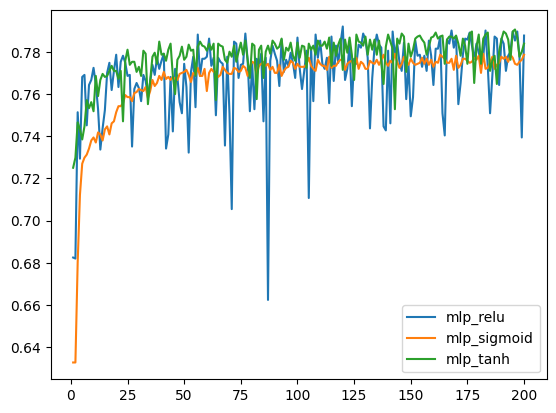

In [176]:
for clf,name in zip([mlp_relu,mlp_sigmoid,mlp_tanh],['mlp_relu','mlp_sigmoid','mlp_tanh']):
    accuracy=clf.get_accuracies()
    plt.plot(np.arange(len(accuracy))+1,accuracy,label=name)
plt.legend()

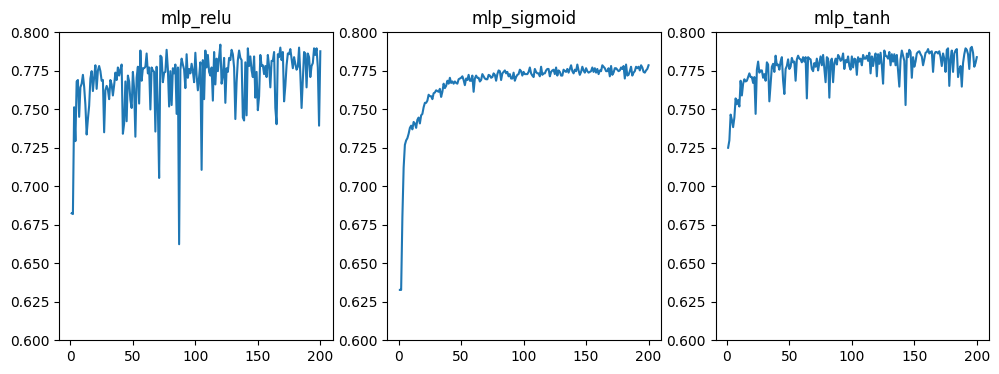

In [177]:
plt.figure(figsize=(12,4))
for clf,name,i in zip([mlp_relu,mlp_sigmoid,mlp_tanh],['mlp_relu','mlp_sigmoid','mlp_tanh'],np.arange(1,4)):
    plt.subplot(1,3,i)
    
    accuracy=clf.get_accuracies()
    plt.plot(np.arange(len(accuracy))+1,accuracy,label=name)
    plt.ylim([0.6,0.8])
    plt.title(name)
plt.show()

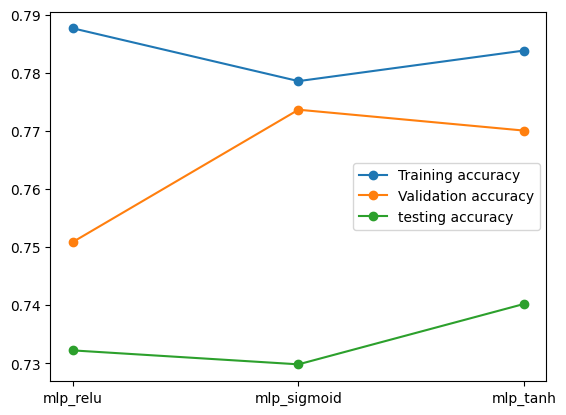

In [178]:
for X,Y,label in zip([X_train,X_valid,X_test],[y_train,y_valid,y_test],['Training accuracy','Validation accuracy','testing accuracy']):
    accuracy=[]
    for clf in [mlp_relu,mlp_sigmoid,mlp_tanh]:
        accuracy.append(clf.score(X.T,Y))
    plt.plot(['mlp_relu','mlp_sigmoid','mlp_tanh'],accuracy,label=label,marker='o')
plt.legend()

plt.show()
    


##Part 4

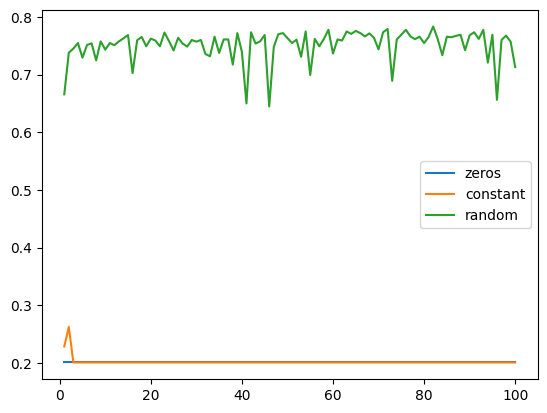

In [171]:
for init_method in ['zeros','constant','random']:
    temp=MLP(X.shape[1],60,len(np.unique(Y)),ReLu,derivReLu,0.5,init_method)
    temp.train(X_train.T,y_train,100,print_accuracy=False,t=500)
    accuracy=temp.get_accuracies()
    plt.plot(np.arange(len(accuracy))+1,accuracy,label=init_method)

plt.legend()
plt.show()


##Part 5

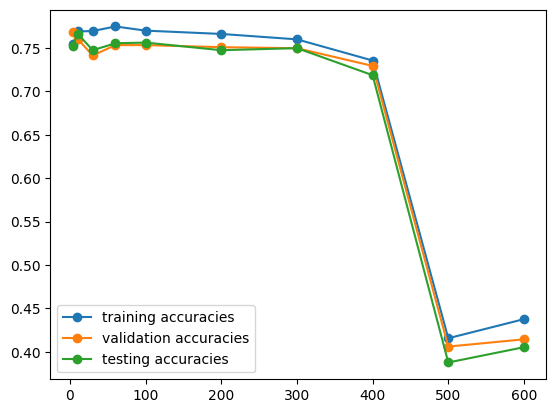

In [15]:
train_accuracies=[]
valid_accuracies=[]
test_accuracies=[]
n_nodes=[4,10,30,60,100,200,300,400,500,600]
for hidden_nodes in n_nodes:
    temp=MLP(X_train.shape[1],hidden_nodes,len(np.unique(y)),ReLu,derivReLu)
    temp.train(X_train.T,y_train,100,print_accuracy=False,t=5)
    train_accuracies.append(temp.score(X_train.T,y_train))
    valid_accuracies.append(temp.score(X_valid.T,y_valid))
    test_accuracies.append(temp.score(X_test.T,y_test))

plt.plot(n_nodes,train_accuracies,label='training accuracies',marker='o')
plt.plot(n_nodes,valid_accuracies,label='validation accuracies',marker='o')
plt.plot(n_nodes,test_accuracies,label='testing accuracies',marker='o')
plt.legend()
plt.show()